# Tutorial 6: Transformers and Multi-head Attention

In [1]:
## Standard libraries
import os
import numpy as np 
import random
import math
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.0.3
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial9"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Scaled Dot Product Attention:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [2]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [3]:
batch_size, seq_len, d_k = 1, 3, 2
q = torch.randn(batch_size, seq_len, d_k)
k = torch.randn(batch_size, seq_len, d_k)
v = torch.randn(batch_size, seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863]]])
K
 tensor([[[ 2.2082, -0.6380],
         [ 0.4617,  0.2674],
         [ 0.5349,  0.8094]]])
V
 tensor([[[ 1.1103, -1.6898],
         [-0.9890,  0.9580],
         [ 1.3221,  0.8172]]])
Values
 tensor([[[ 0.5698, -0.1520],
         [ 0.5379, -0.0265],
         [ 0.2246,  0.5556]]])
Attention
 tensor([[[0.4028, 0.2886, 0.3086],
         [0.3538, 0.3069, 0.3393],
         [0.1303, 0.4630, 0.4067]]])


In [4]:
print((attention[0,0] * v[0,:,0]).sum())
print(attention[0,0])
print(v[0,:,0])

tensor(0.5698)
tensor([0.4028, 0.2886, 0.3086])
tensor([ 1.1103, -0.9890,  1.3221])


Multi-head attention:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where} \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

In [5]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()
        
        
    def _reset_parameters(self):
        pass
        # nn.init.xavier_uniform_(self.qkv_proj.weight)
        # nn.init.xavier_uniform_(self.o_proj.weight)
        
        
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        
        q, k, v = qkv.chunk(3, dim=-1)
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

Encoder-block: combining multi-head attention with linear layer.

In [6]:
class EncoderBlock(nn.Module):
    
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        super().__init__()
        
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        
        return x

In [7]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])
        
    
    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x
    
    
    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

Following block is copied from [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model)

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [9]:
class TransformerPredictor(pl.LightningModule):
    
    
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr=1e-3, dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
        
    
    def _create_model(self):
        self.input_net = nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim,
                                                      dropout=self.hparams.dropout)
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads)
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        ) 
        
    
    def forward(self, x, mask=None, add_positional_encoding=True):
        # if seq_lens is not None:
        #     mask = x.new_zeros(x.size(0), 1, x.size(1), x.size(1))
        #     for i in range(x.size(0)):
        #         mask[i,0,:seq_lens[i],:seq_lens[i]] = 1.0
        # else:
        #     mask = None
            
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x
    
    
    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer
    
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError
    
    
    def validation_step(self, batch, batch_idx):
        raise NotImplementedError    
    
    
    def test_step(self, batch, batch_idx):
        raise NotImplementedError   

## Tasks

* Toy task: reverse input (to visualize attention)
* Set task: Find outlier in set

In [10]:
class ReverseDataset(data.Dataset):
    
    
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        
        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))
        
        
    def __len__(self):
        return self.size
    
    
    def __getitem__(self, idx):
        inp_data = self.data[idx]
        # labels = torch.fmod(inp_data + torch.flip(inp_data, dims=(0,)), self.num_categories)
        labels = torch.flip(inp_data, dims=(0,))
        # labels = torch.fmod(inp_data + 1, self.num_categories)
        return inp_data, labels

In [11]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [12]:
train_loader.dataset[0]

(tensor([3, 0, 0, 2, 2, 6, 1, 7]), tensor([7, 1, 6, 2, 2, 0, 0, 3]))

In [13]:
class ReversePredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [23]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                         gpus=1, 
                         max_epochs=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}
    return model, result

In [24]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=16,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4)
print(reverse_result)

GPU available: True, used: True
I1102 20:35:25.850780 140527318042432 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1102 20:35:25.852739 140527318042432 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1102 20:35:25.854121 140527318042432 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Linear             | 144   
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 2 K   
3 | output_net          | Sequential         | 440   
I1102 20:35:25.885309 140527318042432 lightning.py:1290] 
  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Linear             | 144   
1 | positional_encoding | Posit


{'test': 1.0, 'val': 1.0}


In [25]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [26]:
attention_maps[0].shape

torch.Size([128, 1, 8, 8])

In [27]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    input_data = input_data[idx].detach().cpu().numpy()
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*4, num_layers*4))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0, vmax=1)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
    fig.subplots_adjust(hspace=0.3)
    plt.show()

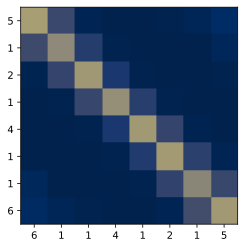

In [28]:
plot_attention_maps(data_input, attention_maps, idx=2)

In [29]:
print(data_input[2])
print(attention_maps[0][2])

tensor([6, 1, 1, 4, 1, 2, 1, 5])
tensor([[[4.7970e-02, 2.6815e-02, 4.4109e-03, 1.4220e-03, 1.7083e-03,
          1.8437e-02, 2.4641e-01, 6.5283e-01],
         [3.1395e-02, 3.0637e-03, 4.6369e-04, 8.0842e-04, 8.5168e-03,
          1.8777e-01, 5.5494e-01, 2.1304e-01],
         [2.8400e-03, 3.8710e-04, 4.2181e-04, 5.5100e-03, 1.4229e-01,
          6.5739e-01, 1.7384e-01, 1.7325e-02],
         [5.7960e-04, 7.2042e-04, 7.4494e-03, 1.2699e-01, 6.5162e-01,
          1.9578e-01, 1.4233e-02, 2.6273e-03],
         [1.0191e-03, 1.0865e-02, 2.0937e-01, 6.0494e-01, 1.6160e-01,
          8.6435e-03, 1.3779e-03, 2.1953e-03],
         [1.3675e-02, 1.9795e-01, 6.4836e-01, 1.2724e-01, 4.4468e-03,
          4.2269e-04, 6.7687e-04, 7.2339e-03],
         [2.3015e-01, 5.7746e-01, 1.5313e-01, 7.5713e-03, 4.0953e-04,
          3.4819e-04, 2.5340e-03, 2.8401e-02],
         [6.7629e-01, 2.1667e-01, 1.8641e-02, 2.2116e-03, 1.0875e-03,
          4.9765e-03, 2.5343e-02, 5.4779e-02]]], device='cuda:0')
